Modify the code
for rk4 method and compute with and without the relativistic correction for Mercury orbiting the Sun. Where the correction term is ~ $\frac{\alpha}{r^4}\vec{r}$, where $\alpha = 0.2$ and is unit less compare with $\alpha = 0.5$ and  $1.0$.

Use Verlet and Euler to compare the stability of orbit with rk4 approach.



a.) Express the problem in dimensionless units. Modify the orbit code to use rk4 and compute Mercury with and without the correction.

$F = ma$
$F_{12} = -F_{21}$
$$m_1 \ddot\vec{{r}} = G\frac{m_1m_2}{|\vec{r_2} - \vec{r_1}|^2} + \frac{\alpha}{|\vec{r_2} - \vec{r_1}|^4}$$
$$-m_2 \ddot\vec{{r}} = -G\frac{m_1m_2}{|\vec{r_2} - \vec{r_1}|^2} - \frac{\alpha}{|\vec{r_2} - \vec{r_1}|^4}$$
Rewriting 
$$m_1 \ddot\vec{{r}} + m_2 \ddot{\vec{r}} = 0$$
$$G\frac{m_1m_2(\vec{r_2} - \vec{r_1})}{|\vec{r_2} - \vec{r_1}|^3} + \frac{\alpha(\vec{r_2} - \vec{r_1})}{|\vec{r_2} - \vec{r_1}|^5} = G\frac{m_1m_2(\vec{r_1} - \vec{r_2})}{|\vec{r_2} - \vec{r_1}|^3} + \frac{\alpha(\vec{r_1} - \vec{r_2})}{|\vec{r_2} - \vec{r_1}|^5}$$

We can construct the distance from the center of mass in terms of $\vec{r_2}$ and $\vec{r_1}$
$m_1 \ddot\vec{{r}} + m_2 \ddot{\vec{r}} = (m_1 + m_2)\frac{m_1\ddot{\vec{r_1}} + m_2\ddot{\vec{r_2}}}{m_1 + m_2} = 0$
$\vec{R} = \frac{m_1\vec{r_1} + m_2\vec{r_2}}{m_1 + m_2}$
$(m_1 + m_2)\ddot{\vec{R}} = 0$

Likewise by a similar method:
$m_2 \ddot\vec{{r_2}} - m_1 \ddot{\vec{r_1}} = $

$\ddot{\vec{r_2}} - \ddot{\vec{r_1}} = \ddot{\vec{r}} = -G\frac{\vec{r}(m_1+m_2)}{|\vec{r}|^3} - \frac{\alpha\vec{r}}{\mu|\vec{r}|^5} = -G\frac{m_1m_2\vec{r}}{\mu|\vec{r}|^3} - \frac{\alpha\vec{r}}{\mu|\vec{r}|^5}$ 

Where $\vec{r} = \vec{r_2} - \vec{r_1}$ and $\mu = \frac{1}{m_1} + \frac{1}{m_2}$

To make the equation dimensionless let $x = \chi x'$, $y = \chi y'$, and $t = \tau t'$
One can also utilize Kepler's Law for the periodicity of the planets motion:
$\tau ^2 = \frac{4\pi^2\chi^3}{G(m_1+m_2)}$ we can solve for $G(m_1+m_2)$

We will non-dimensionalize $\alpha$ later
Breaking $\ddot{\vec{r}}$ into $x$ and $y$:
$\frac{\chi}{\tau^2}\ddot{\vec{x}} = -\frac{4 \pi^2 \chi^3}{\tau^2}\frac{\chi x'}{\chi^3(x'^2 + y'^2)^{3/2}} - \frac{\alpha \chi x'}{\mu\chi^5(x'^2 + y'^2)^{5/2}} = -\frac{4 \pi^2}{\tau^2}\frac{\chi x'}{(x'^2 + y'^2)^{3/2}} - \frac{\alpha \chi x'}{\mu\chi^5(x'^2 + y'^2)^{5/2}}$

$\ddot{\vec{x}} = -\frac{4\pi^2 x'}{(x'^2 + y'^2)^{3/2}}  - \frac{\alpha \tau^2 x'}{\mu\chi^5(x'^2 + y'^2)^{5/2}}$

$\ddot{\vec{y}}$ is derived similarily
Now we must scale $\alpha$ accordingly to cancel our dimensions

$\alpha \propto \frac{\mu \chi^5}{\tau^2}$


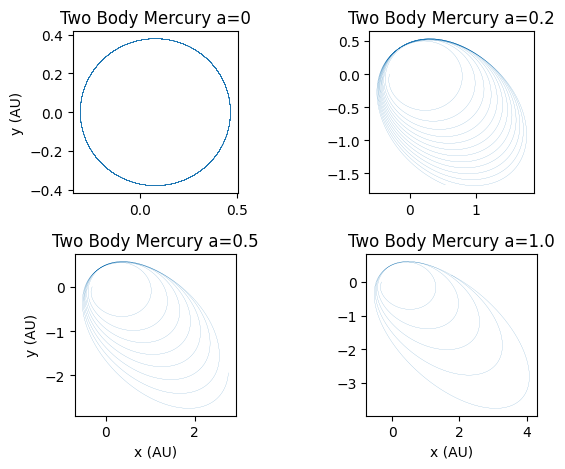

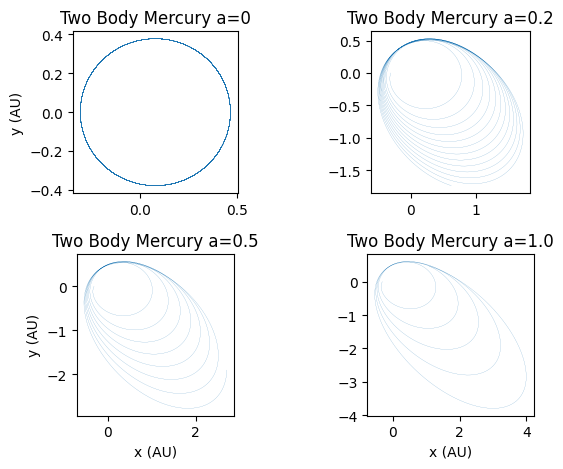

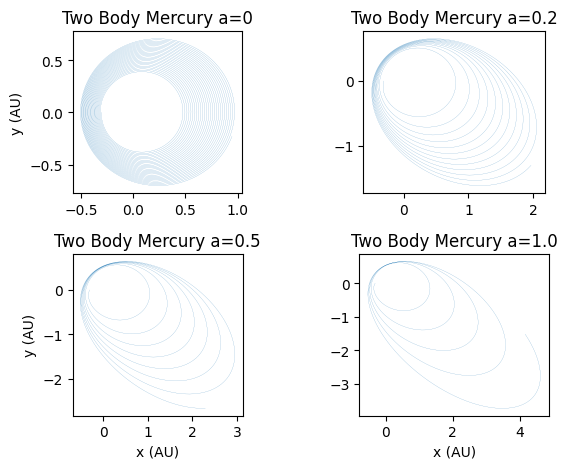

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def evolve(y0: np.ndarray, t0: float, dt: float, n: int,
           f: callable, method: callable, scale=None, param=None) -> np.ndarray:  # type to expect
    dof = len(y0)
    t=t0
    a = []
    y1 = y0.copy()
    if scale is None:
        if param is None:
            for i in range(1, n):
                a.append(y1)
                y1 = method(y1, t, dt, f)
                t += dt
        else:
            for i in range(1, n):
                a.append(y1)
                y1 = method(y1, t, dt, f, param)
                t += dt
    else:
        if len(scale) != dof + 1:
            raise Exception(f'scale vector must have dim={dof + 1}')
        t_scale = scale[0]
        dt = dt/t_scale
        scal = np.array(scale[1:])
        y = y1/scal
        if param is None:
            for i in range(1, n):
                a.append(y1)
                y = method(y, t, dt, f)
                y1 = y*scal
                t += dt
        else:
            for i in range(1, n):
                a.append(y1)
                y = method(y, t, dt, f, param)
                y1 = y*scal
                t += dt
    return np.array(a)


def rk4_step(y:np.ndarray, t:float, dt:float, f:callable, param=None)->np.ndarray:
    if param == None:
        k1 = f(y, t)
        k2 = f(y + k1*dt / 2.0, t + dt / 2.0)
        k3 = f(y + k2*dt / 2.0, t + dt / 2.0)
        k4 = f(y + k3*dt, t+dt)
        k = dt * (k1 + 2*k2 + 2*k3 + k4) / 6.0
        y = y + k
    else:
        k1 = f(y, t, param)
        k2 = f(y + k1*dt / 2.0, t + dt / 2.0, param)
        k3 = f(y + k2*dt / 2.0, t + dt / 2.0, param)
        k4 = f(y + k3*dt, t+dt, param)
        k = dt * (k1 + 2*k2 + 2*k3 + k4) / 6.0
        y = y + k
    return y


def verlet_step(y:np.ndarray, t:float, dt:float, f:callable, param=None)->np.ndarray:
    dof = len(y) // 2
    if param==None:
        for i in range(dof):
            y[2* i + 1] = y[2* i + 1] + dt * f(y, t)[2*i + 1]
            y[2*i] = y[2*i] + dt*f(y, t)[2*i]
        return y
    else:
        for i in range(dof):
            y[2 * i + 1] = y[2 * i + 1] + dt * f(y, t, param)[2 * i + 1]
            y[2 * i] = y[2 * i] + dt * f(y, t, param)[2 * i]
        return y
    
    
def euler_step(y:np.ndarray, t:float, dt:float, f:callable, param=None)->np.ndarray:
    if param==None:
        y = y+dt * f(y, t)
    else:
        y = y + dt * f(y, t, param)
    return y

def orbit(mass1, mass2, perihelion, eccentricity, no_pts, dt, alpha, method):
    def zeta(xi, t=None, param=None):
        #alpha = [0.0, 0.2, 0.5, 1.0]
        #zeta_array = []
        #for a in alpha:
        radius = (xi[0] * xi[0] + xi[1] * xi[1]) ** 1.5
         #   zeta_array.append(np.array([xi[2], xi[3], -4 * np.pi ** 2 * xi[0] / radius, -4 * np.pi ** 2 * xi[1] / radius] + a/radius**4))
        #return zeta_array
        return np.array([xi[2], xi[3], -4 * np.pi ** 2 * xi[0] / radius, -4 * np.pi ** 2 * xi[1] / radius] + alpha/radius**4)
    
    a = perihelion / (1 - eccentricity)
    chi = a

    total_mass = mass1 + mass2
    tau = np.sqrt(
        (4 * np.pi ** 2 * a ** 3) / (G_SI * total_mass)
    )
    velocity = np.sqrt(
        (1 + eccentricity) * G_SI * mass1 / perihelion
    )
    t0 = 0.0
    scale = np.array([tau, chi, chi, chi / tau, chi / tau])  # 2D
    initial_data_array = np.array([perihelion, 0, 0, velocity])
    time = np.arange(0, no_pts * dt, dt)
    #alpha = [0.0, 0.2, 0.5, 1.0]
    #for i in alpha:
    trajectory = evolve(initial_data_array, t0, dt, no_pts, zeta, method,
                        scale)  # implement rk4 in evolution.py
  
    

    complete_traj = []
    for function in trajectory:
        path = [mass2 / total_mass * function[0] / AU, mass2 / total_mass * function[1] / AU,
                    -mass1 / total_mass * function[0] / AU, -mass1 / total_mass * function[1] / AU,
                    mass2 / total_mass * function[2], mass2 / total_mass * function[3],
                    -mass1 / total_mass * function[2], -mass1 / total_mass * function[3]]
        try:    
            complete_traj.append(path)
        except NameError:
            complete_traj = [path]
    return time, complete_traj



G_SI = 6.674E-11 # Universal Gravitation m^3/kg/s^2
G = 1.9935E-44 # AU^3/kg/s^2

C = 4.0*np.pi**2
M_sun = 1.989E30 # kg
M_mercury = 0.33E24 # kg
rp_mercury = 46E9 # m
e_mercury = 0.205
AU = 1.496E11 # s
Year = 31557600 # s

dt = 0.0001 # Yr
dt = dt * Year
alpha_set = [0.0, 0.2, 0.5, 1.0]
methods = [rk4_step, verlet_step, euler_step]

for method in methods:
    time_m = []
    traj_m = []
    for a in alpha_set:
        t_mercury, traj_mercury = orbit(M_sun, M_mercury, rp_mercury, e_mercury, 120000, dt, a, method)
        time_m.append(t_mercury)
        traj_m.append(traj_mercury)
    

    x_mercury_orbit_0 = [frame[2] for frame in traj_m[0]]
    y_mercury_orbit_0 = [frame[3] for frame in traj_m[0]]
    x_mercury_orbit_2 = [frame[2] for frame in traj_m[1]]
    y_mercury_orbit_2 = [frame[3] for frame in traj_m[1]]
    x_mercury_orbit_5 = [frame[2] for frame in traj_m[2]]
    y_mercury_orbit_5 = [frame[3] for frame in traj_m[2]]
    x_mercury_orbit_1 = [frame[2] for frame in traj_m[3]]
    y_mercury_orbit_1 = [frame[3] for frame in traj_m[3]]

    fig, ax = plt.subplots(2, 2)
    ax[0, 0].plot(x_mercury_orbit_0, y_mercury_orbit_0, linewidth=0.1)
    ax[0, 0].set_title(f'Two Body Mercury a=0')
    ax[0, 0].set_aspect('equal')

    ax[0, 1].plot(x_mercury_orbit_2, y_mercury_orbit_2, linewidth=0.1)
    ax[0, 1].set_title(f'Two Body Mercury a=0.2')
    ax[0, 1].set_aspect('equal')

    ax[1, 0].plot(x_mercury_orbit_5, y_mercury_orbit_5, linewidth=0.1)
    ax[1, 0].set_title(f'Two Body Mercury a=0.5')
    ax[1, 0].set_aspect('equal')

    ax[1, 1].plot(x_mercury_orbit_1, y_mercury_orbit_1, linewidth=0.1)
    ax[1, 1].set_title(f'Two Body Mercury a=1.0')
    ax[1, 1].set_aspect('equal')

    ax[0, 0].set(ylabel='y (AU)')
    ax[1, 0].set(ylabel='y (AU)')
    ax[1, 0].set(xlabel='x (AU)')
    ax[1, 1].set(xlabel='x (AU)')
    fig.tight_layout()
    plt.show()
